In [127]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tqdm
from scipy.signal import savgol_filter

from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cuda


In [128]:
t1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
t2 = torch.tensor([[7, 8, 9], [10, 11, 12]])

In [129]:
t1 + t2

tensor([[ 8, 10, 12],
        [14, 16, 18]], device='cuda:0')

In [130]:
t1 * t2

tensor([[ 7, 16, 27],
        [40, 55, 72]], device='cuda:0')

In [131]:
t1.float() @ t2.float().T

tensor([[ 50.,  68.],
        [122., 167.]], device='cuda:0')

In [132]:
torch.argmax(t1)

tensor(5, device='cuda:0')

In [133]:
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 5)
        self.fc2 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()


class ANN_ReLU(ANN):
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ANN_Sigmoid(ANN):
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


class ANN_Tanh(ANN):
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [134]:
x = torch.linspace(-1, 1, 1000).reshape(-1, 1)
y = 2 * x + 1

epochs = 100

In [135]:
def train_model(
    model, x, y, criterion=torch.nn.MSELoss, optimizer=torch.optim.SGD, epochs=epochs
):
    loss_curve = []
    epoch_range = range(epochs)
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=0.01)
    for epoch in epoch_range:
        model.train()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_curve.append(loss.item())
    return epoch_range, loss_curve


def score(model, x, y):
    model.eval()
    with torch.no_grad():
        predictions = model(x)
        mse = torch.mean((predictions - y) ** 2).item()
    return mse

In [136]:
models = {
    "ANN": ANN(),
    "ANN ReLU": ANN_ReLU(),
    "ANN Sigmoid": ANN_Sigmoid(),
    "ANN Tanh": ANN_Tanh(),
}

for name, model in models.items():
    train_model(model, x, y)
    print("Model", name, "Score (MSE):", score(model, x, y), " on", epochs, "epochs")

Model ANN Score (MSE): 0.04514404758810997  on 100 epochs
Model ANN ReLU Score (MSE): 0.6378217935562134  on 100 epochs
Model ANN Sigmoid Score (MSE): 1.0463865995407104  on 100 epochs
Model ANN Tanh Score (MSE): 0.07842811942100525  on 100 epochs


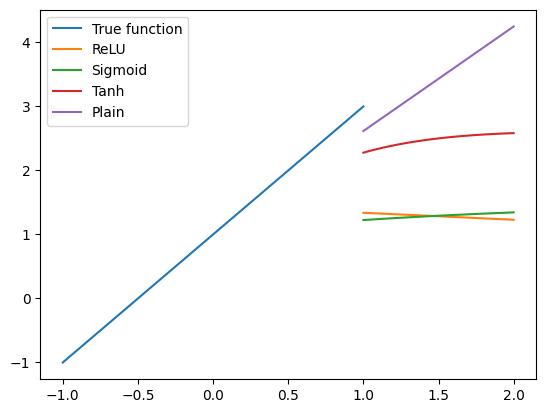

In [137]:
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="True function")
x2 = torch.linspace(1, 2, 100).reshape(-1, 1)
y2 = models["ANN ReLU"](x2)
y3 = models["ANN Sigmoid"](x2)
y4 = models["ANN Tanh"](x2)
y5 = models["ANN"](x2)
plt.plot(x2.detach().cpu().numpy(), y2.detach().cpu().numpy(), label="ReLU")
plt.plot(x2.detach().cpu().numpy(), y3.detach().cpu().numpy(), label="Sigmoid")
plt.plot(x2.detach().cpu().numpy(), y4.detach().cpu().numpy(), label="Tanh")
plt.plot(x2.detach().cpu().numpy(), y5.detach().cpu().numpy(), label="Plain")
plt.legend()
plt.show()

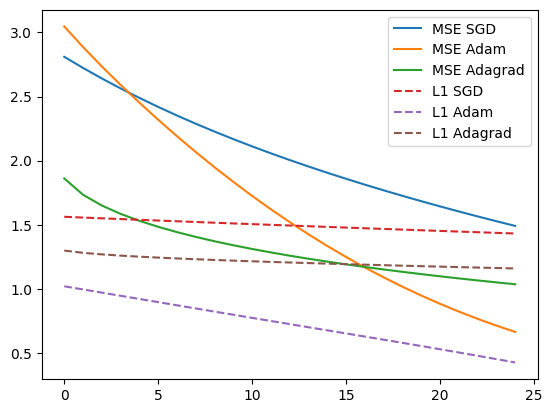

In [138]:
from matplotlib import lines
from sympy import li


ann = models["ANN"]

ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.MSELoss, torch.optim.SGD, epochs=25),
    label="MSE SGD",
)
ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.MSELoss, torch.optim.Adam, epochs=25),
    label="MSE Adam",
)
ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.MSELoss, torch.optim.Adagrad, epochs=25),
    label="MSE Adagrad",
)

ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.L1Loss, torch.optim.SGD, epochs=25),
    label="L1 SGD",
    linestyle="--",
)
ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.L1Loss, torch.optim.Adam, epochs=25),
    linestyle="--",
    label="L1 Adam",
)
ann.reset_parameters()
plt.plot(
    *train_model(ann, x, y, torch.nn.L1Loss, torch.optim.Adagrad, epochs=25),
    linestyle="--",
    label="L1 Adagrad",
)


plt.legend()

In [139]:
bc = load_breast_cancer()

In [140]:
x_bc = torch.tensor(bc.data, dtype=torch.float32)
y_bc = torch.tensor(bc.target, dtype=torch.float32).reshape(-1, 1)

x_train_bc, x_test_bc, y_train_bc, y_test_bc = train_test_split(
    x_bc, y_bc, test_size=0.2
)

x_train_bc, x_val_bc, y_train_bc, y_val_bc = train_test_split(
    x_train_bc, y_train_bc, test_size=0.2
)

train_dataset_bc = TensorDataset(x_train_bc, y_train_bc)
test_dataset_bc = TensorDataset(x_test_bc, y_test_bc)
val_dataset_bc = TensorDataset(x_val_bc, y_val_bc)


generator = torch.Generator(device=device).manual_seed(42)

train_loader_bc = DataLoader(
    train_dataset_bc, batch_size=16, shuffle=True, generator=generator
)
test_loader_bc = DataLoader(
    test_dataset_bc, batch_size=16, shuffle=False, generator=generator
)
val_loader_bc = DataLoader(
    val_dataset_bc, batch_size=16, shuffle=False, generator=generator
)

In [141]:
class ANN_Binary_Classifier(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train_model_bc(
    model,
    train_dataloader,
    val_dataloader,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.SGD,
    epochs=10,
):
    loss_curve = []
    val_curve = []
    epoch_range = range(epochs)
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=3e-4)

    for _ in epoch_range:
        for X, y in train_dataloader:
            model.train()
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            loss_curve.append(loss.item())
            optimizer.step()
        val_curve += val_score_bc(model, val_dataloader, criterion)
    return loss_curve, val_curve


def val_score_bc(model, val_dataloader, criterion):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss.append(loss.item())
    return total_loss


def plot_learning_curve(epochs, loss_curve, val_curve, same_color=False, **args):
    train_label = args.get("label", "Training Loss")
    val_label = args.get("val_label", "Validation Loss")
    plt.figure(figsize=(10, 5))
    x_loss = np.linspace(0, epochs, len(loss_curve))
    x_val = np.linspace(0, epochs, len(val_curve))

    plt.plot(x_loss, loss_curve, label=train_label)
    plt.plot(x_val, val_curve, label=val_label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

In [142]:
model_bc = ANN_Binary_Classifier(x_bc.shape[1])
BC_EPOCHS = 5


train_loss, val_loss = train_model_bc(
    model_bc, train_loader_bc, val_loader_bc, epochs=BC_EPOCHS
)

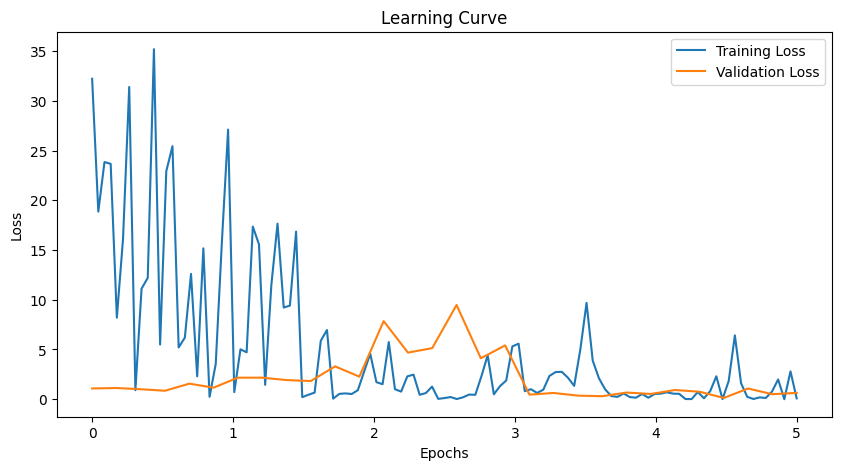

In [143]:
plot_learning_curve(BC_EPOCHS, train_loss, val_loss)

In [144]:
print(
    classification_report(
        y_test_bc.cpu(),
        torch.sigmoid(model_bc(x_test_bc)).cpu().round().detach().numpy(),
    )
)

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84        38
         1.0       0.88      0.99      0.93        76

    accuracy                           0.90       114
   macro avg       0.92      0.86      0.88       114
weighted avg       0.91      0.90      0.90       114



In [145]:
class ANN_BIG(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=1)
        return x

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.fc4.reset_parameters()


class ANN_BIG_Dropout(ANN_BIG):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=1)
        return x


def train_regularized(
    model,
    train_dataloader,
    val_dataloader,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    regularization=None,
    epochs=5,
    l1_lambda=0.001,
    l2_lambda=0.001,
):
    loss_curve = []
    val_curve = []
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=0.001)

    model = model.to(device)

    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)

            if regularization == "l2":
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = criterion(outputs, y) + l2_lambda * l2_norm

            elif regularization == "l1":
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = criterion(outputs, y) + l1_lambda * l1_norm

            else:
                loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()

            loss_curve.append(loss.item())

        val_curve += val_score_bc(model, val_dataloader, criterion)

    return epochs, loss_curve, val_curve

In [146]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
     transforms.Lambda(lambda x: x.view(-1))]
)

mnist_train = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)

generator = torch.Generator(device=device)

mnist_train, mnist_val = torch.utils.data.random_split(
    mnist_train, [0.8, 0.2], generator=generator
)

# mnist_train = torch.utils.data.Subset(mnist_train, range(100))


train_loader_mnist = DataLoader(
    mnist_train, batch_size=64, shuffle=True, generator=generator
)
val_loader_mnist = DataLoader(
    mnist_val, batch_size=64, shuffle=False, generator=generator
)
test_loader_mnist = DataLoader(
    mnist_test, batch_size=64, shuffle=False, generator=generator
)

Training BIG with No Reg


100%|██████████| 30/30 [02:07<00:00,  4.26s/it]


Training BIG with L2 Reg


100%|██████████| 30/30 [02:15<00:00,  4.52s/it]


Training BIG Dropout with No Reg


100%|██████████| 30/30 [02:08<00:00,  4.28s/it]


Training BIG Dropout with L2 Reg


100%|██████████| 30/30 [02:18<00:00,  4.63s/it]


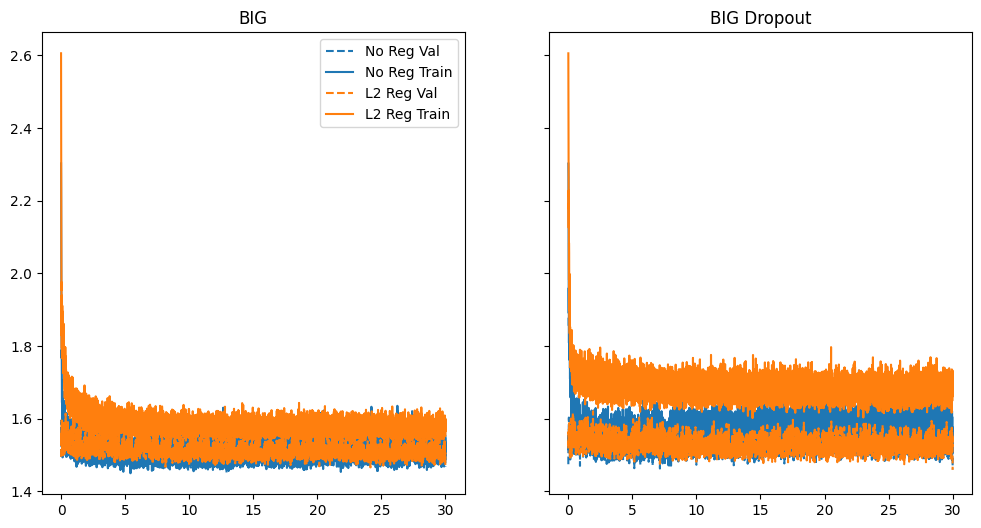

In [147]:
big_models = {
    "BIG": ANN_BIG(28 * 28, 10),
    "BIG Dropout": ANN_BIG_Dropout(28 * 28, 10),
}

training_methods = {
    "No Reg": None,
    "L2 Reg": "l2",
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (big_name, big_model) in zip(axes, big_models.items()):
    for reg_name, reg_method in training_methods.items():
        print(f"Training {big_name} with {reg_name}")
        big_model.reset_parameters()
        epochs, train_loss, val_loss = train_regularized(
            big_model,
            train_loader_mnist,
            val_loader_mnist,
            regularization=reg_method,
            epochs=30,
        )
        x_loss = np.linspace(0, epochs, len(train_loss))
        x_val = np.linspace(0, epochs, len(val_loss))

        val_loss = savgol_filter(val_loss, 5, 3)
        train_loss = savgol_filter(train_loss, 5, 3)

        (base_line,) = ax.plot(x_val, val_loss, linestyle="--", label=f"{reg_name} Val")
        ax.plot(
            x_loss, train_loss, color=base_line.get_color(), label=f"{reg_name} Train"
        )
    ax.set_title(big_name)

axes[0].legend()
plt.show()